In [22]:
# Boilerplate at top of file
# %load_ext autoreload
import rpy2
%load_ext rpy2.ipython
# %autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import os

import seaborn as sns

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
data_dir = '../data/'

direcs = map(lambda x: data_dir + x,[
        'look_left_good/events',
        'look_left_bad/events',
        'look_right_good/events',
        'look_right_bad/events',
    ])
# flatten all event files into a single list of file paths
event_files = reduce(lambda l,r:l + r,
                     map(lambda x: 
                         map(lambda y: x + '/' + y, os.listdir(x)), 
                         direcs
                        )
                    )
# print event_files

# Example of the event data

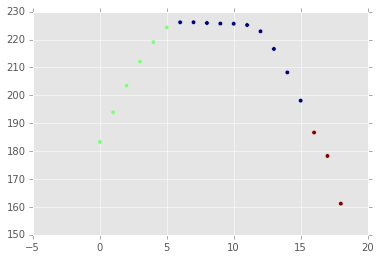

In [11]:
df = pd.read_csv('../data/look_left_good/events/1453773920-0.csv')
plt.scatter(df.index, df['noseX'],c=df['class'])

In [12]:
# bottom = df_a[df_a['faceBottom'] - df_a['faceTop'] != 0]['faceBottom'].mean()
# top = df_a[df_a['faceBottom'] - df_a['faceTop'] != 0]['faceTop'].mean()
# dist = df_a['noseY'].max() - df_a['noseY'].min()
# print dist / abs(top - bottom)

# right = df_a[df_a['faceLeft'] - df_a['faceRight'] != 0]['faceRight'].mean()
# left = df_a[df_a['faceLeft'] - df_a['faceRight'] != 0]['faceLeft'].mean()
# dist = df_a['noseX'].max() - df_a['noseX'].min()
# print dist / abs(right - left)

(array([ 213.,    3.,    3.,    1.,    0.,    1.,    0.,    0.,    0.,    1.]),
 array([  2. ,  10.2,  18.4,  26.6,  34.8,  43. ,  51.2,  59.4,  67.6,
         75.8,  84. ]),
 <a list of 10 Patch objects>)

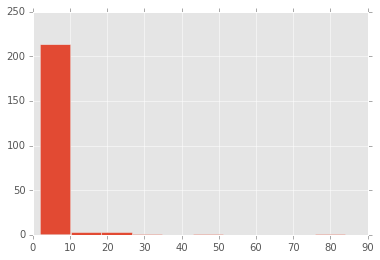

In [13]:
a = []
for f in event_files:
    df_a= pd.read_csv(f)
    a.append(len(df_a[df_a['faceBottom'] - df_a['faceTop'] != 0]))
plt.hist(a)

# Feature Engineering and Exploratory

In [14]:
def generate_signal_features(df, f):
    sampling_rate = (df['time'].max() - df['time'].min()) / len(df)
    df_box = df[df['isFrontFace'] != 0]
    # find the "average" box on the face in the signal
    average_bottom = df_box['faceBottom'].mean()
    average_top = df_box['faceTop'].mean()
    average_left = df_box['faceLeft'].mean()
    average_right = df_box['faceRight'].mean()
    x_dist = df['noseX'].max() - df['noseX'].min(0)
    y_dist = df['noseY'].max() - df['noseY'].min(0)
    speed_norm = df.apply(
        lambda x: np.linalg.norm([x['noseX_1_steps'], x['noseY_1_steps']]), 
        axis=1,
        )
    data_points = float(len(df))
    row=dict()
    row['signal_length'] = df['time'].max() - df['time'].min()
#     row['noseX_delta_max'] = df['noseX'].max() - df['noseX'].min(0)
    row['delta_x'] = abs(x_dist / (average_right - average_left))
    row['delta_y'] = abs(y_dist / (average_top - average_bottom))

    row['front_face_count'] = sum(df['isFrontFace'] == 1) / data_points
    row['slowSpeedCount'] = sum(speed_norm < 1)

    row['good_turn'] = str(df['turn_sentiment'].max().find('good') != -1)
    row['file_name'] = f
    return row

def feature_diagnostics(df, f):
    pass

In [28]:
events = []
for f in event_files:
    row = generate_signal_features(pd.read_csv(f), f)
    events.append(row)
df_events = pd.DataFrame(events)
#class_col = 'turn_sentiment'
class_col = 'good_turn'
Y = LabelEncoder().fit_transform(df_events[class_col])

active_features = df_events._get_numeric_data().columns.tolist()
df_num = df_events[active_features]
df_a = df_events[active_features + [class_col]]
print active_features

['delta_x', 'delta_y', 'front_face_count', 'signal_length', 'slowSpeedCount']


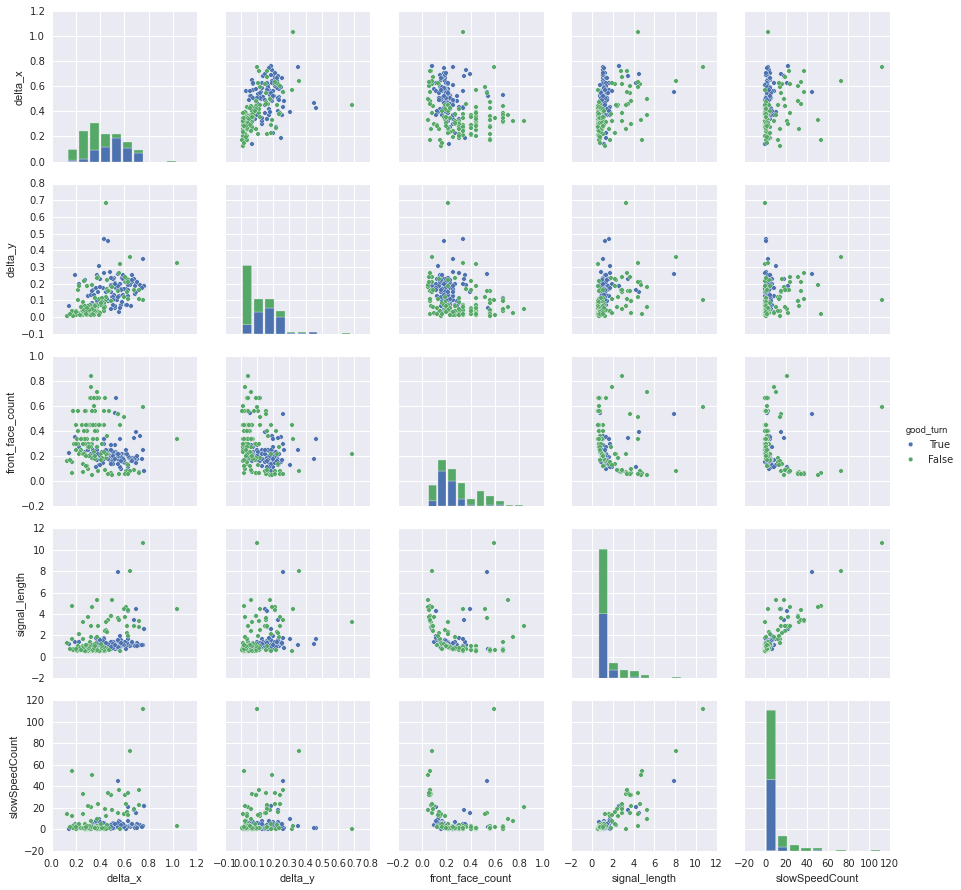

In [31]:

sns.pairplot(df_a, hue="good_turn")

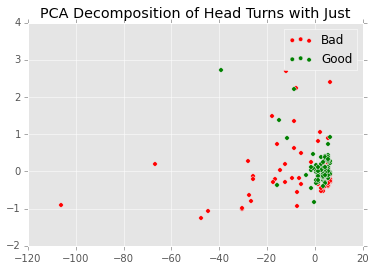

In [17]:
pca = PCA(n_components=2)
X = pca.fit_transform(df_events[active_features])
plt.scatter(X[Y==0,0], X[Y==0,1], c = 'red', label='Bad')
plt.scatter(X[Y==1,0], X[Y==1,1], c = 'green', label='Good')
plt.title("PCA Decomposition of Head Turns with Just ")
plt.legend()
# red is good head turns
# blue is bad behavior

# Classifier

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score


In [20]:
def train_split_classify(df, active_features, y_feature, clf, k = 10):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    accuracies = []
    recalls = []
    precisions = []
    cof_mat = []
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        cof_mat.append(confusion_matrix(Y_pred, Y_test))
        accuracies.append(accuracy_score(Y_pred, Y_test))
        recalls.append(recall_score(Y_pred, Y_test))
        precisions.append(precision_score(Y_pred, Y_test))
        
    print 'Confusion Matrix:', sum(cof_mat)
    print 'Accuracy:', np.mean(accuracies)
    print 'Recall:', np.mean(recalls)
    print 'Precision:', np.mean(precisions)
    

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
svm = SVC()
glm = LogisticRegression()
dt = DecisionTreeClassifier()

train_split_classify(df_events, active_features, class_col, rf)
train_split_classify(df_events, active_features, class_col, svm)
train_split_classify(df_events, active_features, class_col, glm)
train_split_classify(df_events, active_features, class_col, dt)



Cross validating for <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Confusion Matrix: [[353  65]
 [ 17 235]]
Accuracy: 0.877611940299
Recall: 0.933383320383
Precision: 0.783333333333


Cross validating for <class 'sklearn.svm.classes.SVC'>
Confusion Matrix: [[310  80]
 [ 60 220]]
Accuracy: 0.791044776119
Recall: 0.785714285714
Precision: 0.733333333333


Cross validating for <class 'sklearn.linear_model.logistic.LogisticRegression'>
Confusion Matrix: [[330  90]
 [ 40 210]]
Accuracy: 0.805970149254
Recall: 0.84
Precision: 0.7


Cross validating for <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Confusion Matrix: [[329  49]
 [ 41 251]]
Accuracy: 0.865671641791
Recall: 0.859622331691
Precision: 0.836666666667
